In [1]:
import logging

logging.basicConfig(level=logging.INFO)

In [2]:
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
from torch.optim import SGD, Adam
from torch.nn import CrossEntropyLoss, MSELoss

# from pennylane import NesterovMomentumOptimizer

from qcc.ml.data import Data, BinaryData
from qcc.ml.optimize import Optimizer
from qcc.ml.data import ImageTransform, ImageTransform1D, ClassicalImageTransform
from qcc.experiment import Experiment
from qcc.ml.model import Model

from pathlib import Path
from qcc.file import new_dir

# from qcc.quantum.pennylane.ansatz import MQCCOptimized as Module
from qcc.ml.cnn import ConvolutionalNeuralNetwork as Module

# from qcc.quantum.pennylane.ansatz.basic import BasicFiltering6
from qcc.quantum.pennylane.fully_connected import FullyConnected
from qcc.quantum.pennylane.c2q import ConvolutionAngleFilter, ConvolutionComplexAngleFilter, ConvolutionFilter
from qcc.quantum.pennylane.convolution import define_filter

INFO:qcc.ml.ml:Using CUDA on device cuda


In [3]:
# Meta parameters
name = "cnn"
filename = Path(f"results/{name}")
num_trials = 1
silent = False
is_quantum = False

# Ansatz parameters
dims = (16, 16, 3)
num_layers = 4
module_options = {
    # "U_filter": ConvolutionAngleFilter,
    # "pre_op": True,
    "num_features": 4,
    # "U_fully_connected": define_filter(num_layers=2),
    # # "pooling": True,
    # # "filter_shape": (2, 2, 2),
    # "q2c_method": "parity"
}

In [4]:
filename = new_dir(filename, overwrite=True)
filename = filename / name

if is_quantum:
    module = Module.from_dims
else:
    module = Module

# Create module
module = module(
    dims,
    num_layers=num_layers,
    **module_options,
)
data = BinaryData(
    CIFAR10,
    ImageTransform(dims) if is_quantum else ClassicalImageTransform(dims),
    batch_size=(8,1000),
)
optimizer = Optimizer(Adam)
loss = CrossEntropyLoss()
model = Model.with_logging(module, data, optimizer, loss, epoch=8)

# Log important values
model.logger.info(f"Circuit ID: {name}")
model.logger.info(f"{module=}")
model.logger.info(f"{data=}")
model.logger.info(f"{optimizer=}")
model.logger.info(f"{loss=}")

model.logger.info(f"{num_trials=}")
model.logger.info(f"{dims=}")
model.logger.info(f"{num_layers=}")
# model.logger.info(f"{1=}")
model.logger.info(f"{module_options=}")

# Save circuit drawing
if is_quantum:
    filename = filename.with_stem(f"{name}_circuit")
    module.draw(filename=filename, decompose=True)

2023-10-17 23:11:13,470: (convolutionalneuralnetwork) Circuit ID: cnn
2023-10-17 23:11:13,471: (convolutionalneuralnetwork) module=ConvolutionalNeuralNetwork(
  (0): Conv2d(3, 4, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Conv2d(4, 4, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): ReLU()
  (6): Conv2d(4, 4, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): ReLU()
  (9): Conv2d(4, 4, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): ReLU()
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=4, out_feat

In [5]:
# Run experiment
results_schema = ["accuracy", "training_time", "testing_time"]
experiment = Experiment(model, num_trials, results_schema)
# experiment.partial(silent=silent)
results = experiment(filename=filename)

Files already downloaded and verified
Files already downloaded and verified


2023-10-17 23:11:14,535: (convolutionalneuralnetwork) Number of Parameters: 266
2023-10-17 23:11:19,796: (convolutionalneuralnetwork) (Epoch 1) Training took 3.05129 sec
2023-10-17 23:11:19,998: (convolutionalneuralnetwork) (Epoch 1) Testing took: 0.20115 sec
2023-10-17 23:11:19,999: (convolutionalneuralnetwork) (Epoch 1) Accuracy: 73.450%
2023-10-17 23:11:25,054: (convolutionalneuralnetwork) (Epoch 2) Training took 6.05006 sec
2023-10-17 23:11:25,276: (convolutionalneuralnetwork) (Epoch 2) Testing took: 0.22106 sec
2023-10-17 23:11:25,277: (convolutionalneuralnetwork) (Epoch 2) Accuracy: 79.600%


2023-10-17 23:07:35,681: (convolutionalneuralnetwork) accuracy: median=0.8265000581741333, mean=0.8265000581741333, max=0.8265000581741333, min=0.8265000581741333, std=None
2023-10-17 23:07:35,682: (convolutionalneuralnetwork) training_time: median=33.328492765, mean=33.328492765, max=33.328492765, min=33.328492765, std=None
2023-10-17 23:07:35,683: (convolutionalneuralnetwork) testing_time: median=0.21887134300000355, mean=0.21887134300000355, max=0.21887134300000355, min=0.21887134300000355, std=None


(<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>)

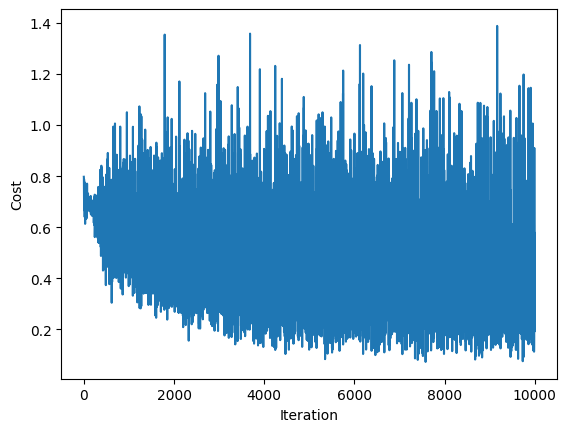

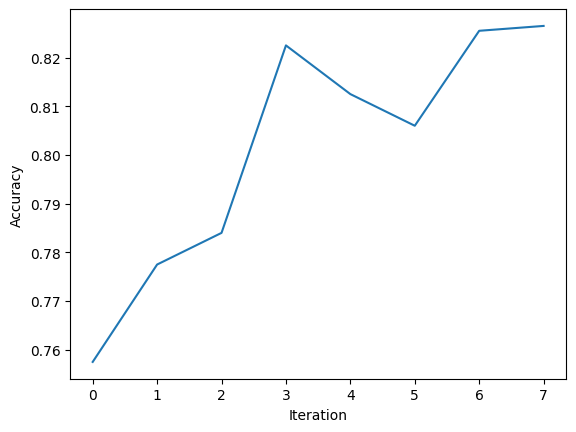

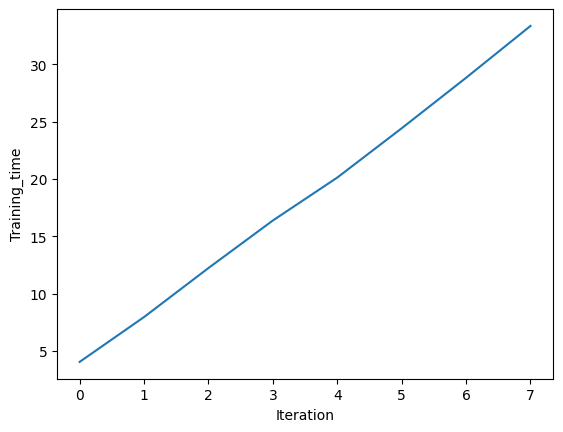

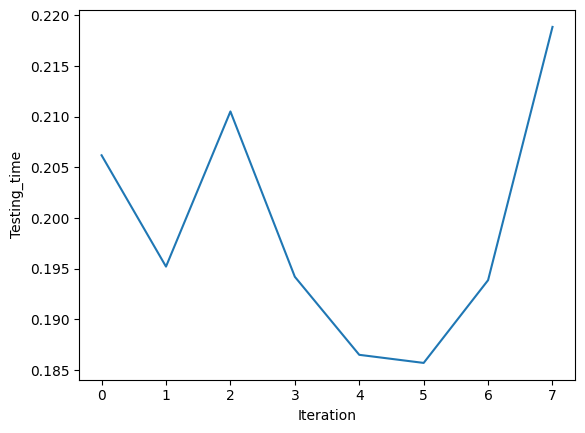

In [ ]:
# Print accuracy results
metrics = ("median", "mean", "max", "min", "std")
for name in results.columns:
    col = results[name]
    msg = (f"{metric}={getattr(col, metric)()}" for metric in metrics)
    msg = ", ".join(msg)
    msg = f"{name}: {msg}"
    model.logger.info(msg)

# Save aggregated loss history figure
display(experiment.draw(filename))